# TODO:
- I guess give up on OPR for time being?
    - switch to direct MAT reading with layer and layerData functions
        - verify vs. OPR echograms
    - schedule time with John to review the python code and see what changed in OPR

In [1]:
from project_classes import *
from functions import *
from iceflow_library import *

In [6]:
zoom = True
seg_length = 100
season = "2018_Antarctica_DC8" # a layerData season
season = "2016_Antarctica_DC8" # a season with both layer and layerData
# season = "2014_Antarctica_DC8" # a layerData season
flight = "20181030_01"  # the flight date and frame number
flight = "20181103_01"
# flight = "20181112_02"  # the problem flight
flight = "20161024_05"
# flight = '20141026_06'
file_name = "layer_export_" + flight + ".pickle"
testing = False

### read in the layers from the layer files and save them to a pickle file

In [8]:
# if the file at filename exists, read in the layers from the pickle file
# otherwise, read in the layers from the layer files and save them to a pickle file
# if not os.path.isfile(file_name):  # if the file does not exist
#     print(f"File {file_name} does not exist. Making it...")
#     # mat_pickler_layerData(season, flight, testing_mode=testing, layer=True)  # make it
#     mat_pickler_layerData(season, flight, testing_mode=testing, layer=False)  # make it
# mat_pickler_layerData(season, flight, testing_mode=testing)  # make it
mat_pickler_layer(season, flight, testing_mode=testing)  # make it
layers = read_layers(file_name)  # read in the layers from the pickle file

Reading data files...
--------------------
layer_attributes_file: layer_20161024_05.mat
DATA MAT FILE KEYS:
header, version, globals, elev, file_type, file_version, gps_time, id, lat, lon, param, quality, twtt, type
LAYER ATTRIBUTES MAT FILE KEYS:
header, version, globals, file_type, file_version, lyr_age, lyr_age_source, lyr_desc, lyr_group_name, lyr_id, lyr_name, lyr_order, param
--------------------

debug:
data_mat type: <class 'dict'>
data_mat[0] keys:
header, version, globals, elev, file_type, file_version, gps_time, id, lat, lon, param, quality, twtt, typetwtt: [[5.54517000e-05 5.54517000e-05 5.54517000e-05 ... 5.83841740e-05
  5.83865502e-05 5.83890996e-05]
 [           nan            nan            nan ... 6.36720058e-05
  6.36575653e-05 6.36488182e-05]
 [           nan            nan            nan ...            nan
             nan            nan]]
twtt[0]: [5.54517000e-05 5.54517000e-05 5.54517000e-05 ... 5.83841740e-05
 5.83865502e-05 5.83890996e-05]
twtt[0][0]: 5.54517e-

In [9]:
print(layers[0].twtt[0])
print(layers[0].twtt[10])
print(layers[0].twtt[20])
print(layers[0].twtt[30])
print(layers[0].twtt[40])

5.54517e-05
5.5453412848255724e-05
5.54546e-05
5.54546e-05
5.547124219271211e-05


### read in the iceflow data from the iceflow data files and save them to a pickle file

In [10]:
try:
    iceflow_data = iceflow_data_file_loader()
    print("The iceflow data pickle file was found and loaded.")
except FileNotFoundError:
    print("The iceflow data pickle file was not found. Creating a new one...")
    filename = iceflow_saver()
    iceflow_data = iceflow_loader(filename)
    print("The iceflow data pickle file was successfully created.")
    
x = iceflow_data[0]
y = iceflow_data[1]
velocity_x = iceflow_data[2]
velocity_y = iceflow_data[3]
latitude = iceflow_data[4]
longitude = iceflow_data[5]

The iceflow data pickle file was found and loaded.


# next step: continue working through crossover.py to rebuild the code

In [11]:
intersection_points_base, intersection_indices_base, segment_ends = cross_point(layers[0], seg_length, quiet=True)
# find the crossover points
print(f"len(intersection_indices): {len(intersection_indices_base)}")
print(f"len(intersection_points): {len(intersection_points_base)}")

Finding crossover point...
--------------------
Checking for intersections...
Number of intersections: 10
Index 0: 
indices: 	[27259, 110002]
lat-lon: 	(-81.11805741453195, -29.734744400231527)
segment ends: 	[[(-81.11816244525122, -29.73509516444382), (-81.11804305866158, -29.73469645687178)], [(-81.11805932746817, -29.734692394860527), (-81.11802820171967, -29.735538584123283)]]
lat-lon by layer: 	(-81.11816244525122, -29.73509516444382)
Index 1: 
indices: 	[33472, 108322]
lat-lon: 	(-81.16770118306837, -28.305846101207493)
segment ends: 	[[(-81.16768709742837, -28.30579867911967), (-81.16780642066725, -28.306200404359963)], [(-81.16772410189748, -28.305143441473003), (-81.16769619365431, -28.305999069770742)]]
lat-lon by layer: 	(-81.16768709742837, -28.30579867911967)
Index 2: 
indices: 	[43768, 105222]
lat-lon: 	(-81.23888292313913, -25.623627757303908)
segment ends: 	[[(-81.23895935598836, -25.623889163118154), (-81.23884022806007, -25.623481737078055)], [(-81.2388842805298, -25.

In [21]:
def plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=False, refractive_index=1.77,
                         cross_index=0):
    """
    :param layers: a list of Layer objects
    :param intersection_indices: a list of indices in the lat-lon arrays where the flight path
    crosses over itself
    :param intersection_points: a list of lat-lon points where the flight path crosses over itself
    :return: nothing (plots the layers and the map)
    """
    plt.figure(figsize=(24, 12), layout='constrained')
    print("Plotting layers and map...")
    print("--------------------")
    print("Adjusting for surface twtt...")
    for layer in layers:
        corrected_layer = layer.twtt - layers[0].twtt
        layer.twtt_corrected = corrected_layer

    # ax2 will be the layer plot
    plt.subplot(1, 2, 1)

    # plot the layer depths vs index for 500 points before and after the first
    # crossover point for each layer.
    # also plot the layer depths vs index for 500 points before and after the
    # second crossover point for each layer.
    offset = 500
    # plot the corrected twtt for each layer
    plt.plot(
        layers[0].twtt_corrected[intersection_indices[0][0] - offset:intersection_indices[cross_index][0] + offset],
        label=layers[0].layer_name)
    plt.plot(
        layers[1].twtt_corrected[intersection_indices[0][0] - offset:intersection_indices[cross_index][0] + offset],
        label=layers[1].layer_name + ' segment 1')
    plt.plot(
        layers[1].twtt_corrected[intersection_indices[0][1] - offset:intersection_indices[cross_index][1] + offset],
        label=layers[1].layer_name + ' segment 2')

    # plot uncorrected twtt for each layer
    # plt.plot(layers[0].twtt[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
    #             label=layers[0].layer_name)
    # plt.plot(layers[1].twtt[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
    #             label=layers[1].layer_name + ' segment 1')
    # plt.plot(layers[1].twtt[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset],
    # label=layers[1].layer_name + ' segment 2')

    # invert the y-axis because the twtt increases with depth
    plt.gca().invert_yaxis()
    # plot the crossover point on the plot
    plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                      intersection_indices, quiet=True)[0][0], color='red',
                label='X Point 1')
    plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                      intersection_indices, quiet=True)[0][1], color='green',
                label='X Point 2')
    # plot a line at the crossover point
    plt.axvline(x=offset, color='black', label='X Point', linestyle='--', linewidth=0.3)

    # set the y axis to be in nanoseconds instead of seconds
    plt.ylabel("Adjusted Two Way Travel Time (ns)")
    plt.xlabel("Index")

    # force the y values to be displayed in 1e-6 ticks (microseconds) instead of 1e-5 ticks (tens of microseconds)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)

    def s_to_ms(x, pos):
        """
        :param x: the x value
        :param pos: the position
        :return: the x value in milliseconds
        """
        return '%1.1f' % (x * 1e6)

    # set the y axis to be in microseconds instead of seconds
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(s_to_ms))

    # make the right side y axis show the depth in meters by converting the twtt to depth using the refractive index
    min_y, max_y = plt.ylim()
    n = refractive_index
    c = 299792458  # m/s
    v = c / n
    # depth = twtt * v / 2
    scale_factor = v / 2
    print(f"scale factor: {scale_factor}")
    plt.twinx()
    plt.ylim(min_y * scale_factor, max_y * scale_factor)
    plt.ylabel("Depth (m)")

    # make the top of the x axis be the distance in meters by converting the lat-lon to distance using the haversine formula
    min_x, max_x = plt.xlim()
    scale_factor = latlon_dist((layers[0].lat[0], layers[0].lon[0]), (layers[0].lat[1], layers[0].lon[1]))
    print(f"scale factor: {scale_factor}")
    plt.twiny()
    plt.xlim(min_x * scale_factor, max_x * scale_factor)
    plt.xlabel("Distance (m)")

    plt.title("Adjusted Two Way Travel Time vs Index")
    plt.legend(["legend"], fontsize='smaller', loc='upper right', bbox_to_anchor=(1.1, 1.1))

    """
    plot the map
    """
    plt.subplot(1, 2, 2)

    # TODO: add an offset to the zoom settings so that the crossover point is in the center of the zoomed in map

    # # this code sets up a polar stereographic map of antarctica with the South Pole in the center
    zoom_out_to_continent = not zoom
    if zoom_out_to_continent:
        llcrnrx = -400000
        llcrnry = -400000
        urcrnrx = 250000
        urcrnry = 250000
    else:
        llcrnrx= -50000
        llcrnry= -50000
        urcrnrx= 50000
        urcrnry= 50000
    lat_0 = intersection_points[cross_index][0]
    lon_0 = intersection_points[cross_index][1]
    m = Basemap(projection='ortho', lat_0=lat_0, lon_0=lon_0, llcrnrx=llcrnrx,
                llcrnry=llcrnry, urcrnrx=urcrnrx, urcrnry=urcrnry, resolution='c')

    m.drawcoastlines()
    m.fillcontinents(color='grey', lake_color='aqua')
    m.drawparallels(np.arange(-80., 81., 20.))
    m.drawmeridians(np.arange(-180., 181., 20.))
    m.drawmapboundary(fill_color='aqua')

    # plot the flight path
    m.plot(layers[0].lon, layers[0].lat, latlon=True, color='lightgreen', linewidth=1)
    # plot the section of the flight path in the plot above
    m.plot(layers[0].lon[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
           layers[0].lat[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset], latlon=True,
           color='red', linewidth=1)
    m.plot(layers[0].lon[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset],
           layers[0].lat[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset], latlon=True,
           color='green', linewidth=1)
    # plot labels for the flight paths at their start points
    plt.text(
        m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[
            0],
        m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[
            1], '\nsegment 1', fontsize='smaller', fontweight='bold', ha='right', va='top', color='red')
    plt.text(
        m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[
            0],
        m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[
            1], '\nsegment 2', fontsize='smaller', fontweight='bold', ha='left', va='top', color='green')
    # plot the South Pole
    m.scatter(0, -90, latlon=True, color='black', linewidth=1, label='South Pole')
    # plot the crossover points
    for point in intersection_points:
        m.scatter(point[1], point[0], latlon=True, color='darkred', linewidth=1, label='Crossover Point')
        plt.text(m(point[1], point[0])[0], m(point[1], point[0])[1] - 10000, 'Crossover Point\n\n',
                 fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # m.scatter(intersection_points[cross_index][1], intersection_points[cross_index][0], latlon=True, color='darkred',
    #           linewidth=1, label='Crossover Point')
    # plt.text(m(intersection_points[cross_index][1], intersection_points[cross_index][0])[0],
    #          m(intersection_points[cross_index][1], intersection_points[cross_index][0])[1] - 10000,
    #          'Crossover Point\n\n',
    #          fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # plot the crossover line

    x, y = m(0, -90)
    plt.text(x, y, '\nSouth Pole', fontsize='smaller', fontweight='bold', ha='center', va='top', color='black')
    plt.title("Lat-Lon Map")
    # set tight layout
    # plt.tight_layout()

    # save the plot
    plt.savefig("layer_plot.png", dpi=250)

    plt.show()

    print("plotted map")
    print("--------------------\n")

In [22]:
plot_layers_at_cross(layers[0], intersection_indices_base, segment_ends, zoom=zoom)

Plotting layers and map...
--------------------
Adjusting for surface twtt...


TypeError: 'Layer' object is not iterable

<Figure size 2400x1200 with 0 Axes>

Plotting layers and map...
--------------------
Adjusting for surface twtt...
scale factor: 84687135.0282486
scale factor: 14.936579591230279


C:\Users\rj\AppData\Local\Temp\ipykernel_25960\1009130602.py:169: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("layer_plot.png", dpi=250)
C:\Users\rj\Documents\cresis_project\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


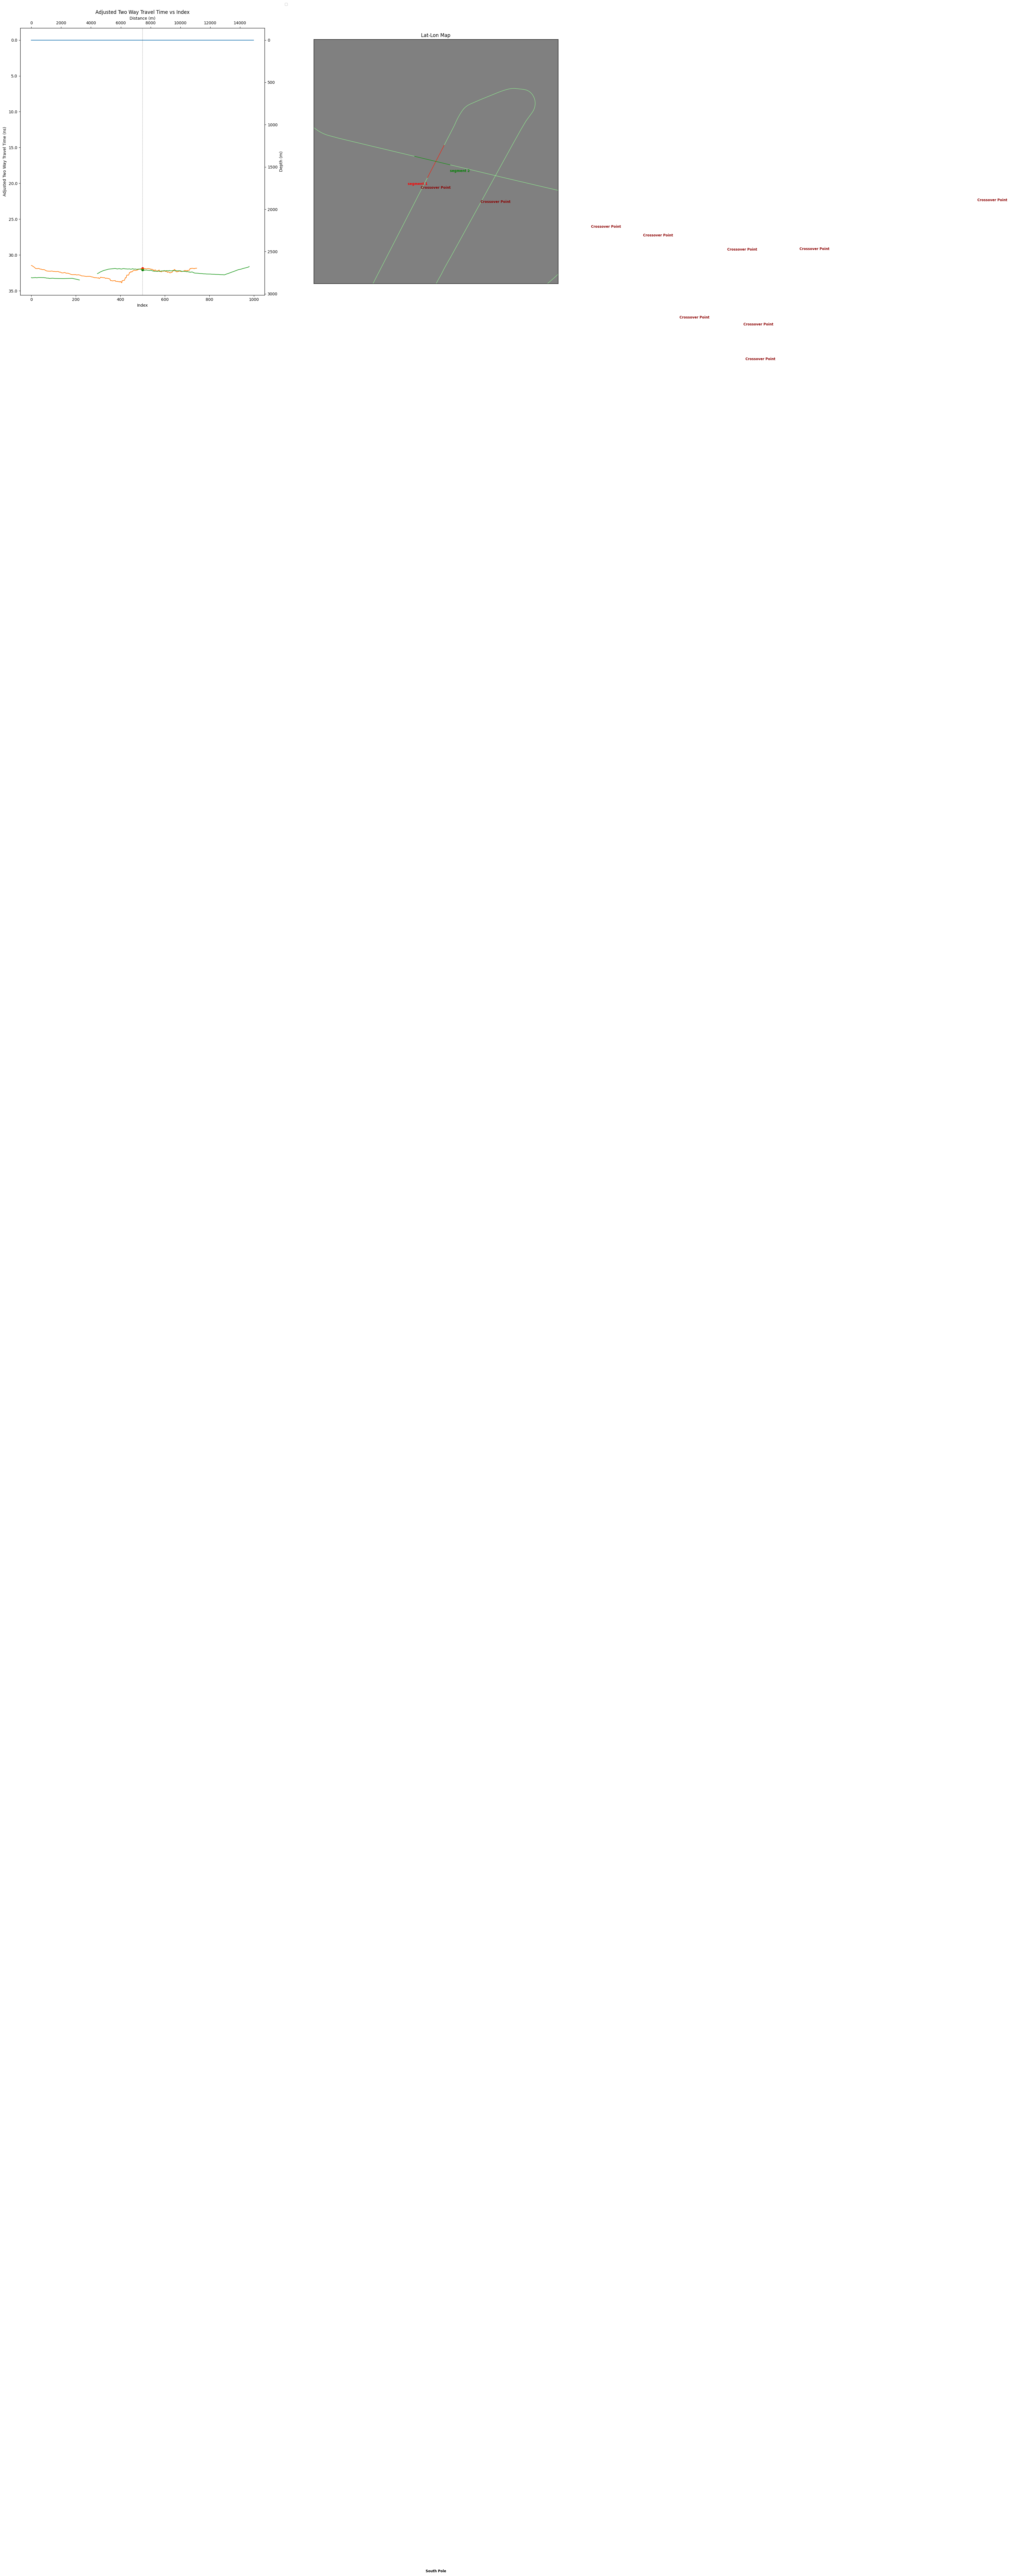

plotted map
--------------------


In [27]:
# This is a reproduction of plot_layers_at_cross()
"""
TODO: figure out why the original function errors out on 
---> 14 for layer in layers:
     15     corrected_layer = layer.twtt - layers[0].twtt
     16     layer.twtt_corrected = corrected_layer
"""
TypeError: 'Layer' object is not iterable

intersection_indices = intersection_indices_base
cross_index = 0
refractive_index = 1.77
intersection_points = intersection_points_base

plt.figure(figsize=(24, 12), layout='constrained')
print("Plotting layers and map...")
print("--------------------")
print("Adjusting for surface twtt...")
for layer in layers:
    corrected_layer = layer.twtt - layers[0].twtt
    layer.twtt_corrected = corrected_layer

# ax2 will be the layer plot
plt.subplot(1, 2, 1)

# plot the layer depths vs index for 500 points before and after the first
# crossover point for each layer.
# also plot the layer depths vs index for 500 points before and after the
# second crossover point for each layer.
offset = 500
# plot the corrected twtt for each layer
plt.plot(
    layers[0].twtt_corrected[intersection_indices[0][0] - offset:intersection_indices[cross_index][0] + offset],
    label=layers[0].layer_name)
plt.plot(
    layers[1].twtt_corrected[intersection_indices[0][0] - offset:intersection_indices[cross_index][0] + offset],
    label=layers[1].layer_name + ' segment 1')
plt.plot(
    layers[1].twtt_corrected[intersection_indices[0][1] - offset:intersection_indices[cross_index][1] + offset],
    label=layers[1].layer_name + ' segment 2')

# plot uncorrected twtt for each layer
# plt.plot(layers[0].twtt[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
#             label=layers[0].layer_name)
# plt.plot(layers[1].twtt[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
#             label=layers[1].layer_name + ' segment 1')
# plt.plot(layers[1].twtt[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset],
# label=layers[1].layer_name + ' segment 2')

# invert the y-axis because the twtt increases with depth
plt.gca().invert_yaxis()
# plot the crossover point on the plot
plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                  intersection_indices, quiet=True)[0][0], color='red',
            label='X Point 1')
plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                  intersection_indices, quiet=True)[0][1], color='green',
            label='X Point 2')
# plot a line at the crossover point
plt.axvline(x=offset, color='black', label='X Point', linestyle='--', linewidth=0.3)

# set the y axis to be in nanoseconds instead of seconds
plt.ylabel("Adjusted Two Way Travel Time (ns)")
plt.xlabel("Index")

# force the y values to be displayed in 1e-6 ticks (microseconds) instead of 1e-5 ticks (tens of microseconds)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)

def s_to_ms(x, pos):
    """
    :param x: the x value
    :param pos: the position
    :return: the x value in milliseconds
    """
    return '%1.1f' % (x * 1e6)

# set the y axis to be in microseconds instead of seconds
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(s_to_ms))

# make the right side y axis show the depth in meters by converting the twtt to depth using the refractive index
min_y, max_y = plt.ylim()
n = refractive_index
c = 299792458  # m/s
v = c / n
# depth = twtt * v / 2
scale_factor = v / 2
print(f"scale factor: {scale_factor}")
plt.twinx()
plt.ylim(min_y * scale_factor, max_y * scale_factor)
plt.ylabel("Depth (m)")

# make the top of the x axis be the distance in meters by converting the lat-lon to distance using the haversine formula
min_x, max_x = plt.xlim()
scale_factor = latlon_dist((layers[0].lat[0], layers[0].lon[0]), (layers[0].lat[1], layers[0].lon[1]))
print(f"scale factor: {scale_factor}")
plt.twiny()
plt.xlim(min_x * scale_factor, max_x * scale_factor)
plt.xlabel("Distance (m)")

plt.title("Adjusted Two Way Travel Time vs Index")
plt.legend(["legend"], fontsize='smaller', loc='upper right', bbox_to_anchor=(1.1, 1.1))

"""
plot the map
"""
plt.subplot(1, 2, 2)

# TODO: add an offset to the zoom settings so that the crossover point is in the center of the zoomed in map

# # this code sets up a polar stereographic map of antarctica with the South Pole in the center
zoom_out_to_continent = not zoom
if zoom_out_to_continent:
    llcrnrx = -400000
    llcrnry = -400000
    urcrnrx = 250000
    urcrnry = 250000
else:
    llcrnrx= -50000
    llcrnry= -50000
    urcrnrx= 50000
    urcrnry= 50000
lat_0 = intersection_points[cross_index][0]
lon_0 = intersection_points[cross_index][1]
m = Basemap(projection='ortho', lat_0=lat_0, lon_0=lon_0, llcrnrx=llcrnrx,
            llcrnry=llcrnry, urcrnrx=urcrnrx, urcrnry=urcrnry, resolution='c')

m.drawcoastlines()
m.fillcontinents(color='grey', lake_color='aqua')
m.drawparallels(np.arange(-80., 81., 20.))
m.drawmeridians(np.arange(-180., 181., 20.))
m.drawmapboundary(fill_color='aqua')

# plot the flight path
m.plot(layers[0].lon, layers[0].lat, latlon=True, color='lightgreen', linewidth=1)
# plot the section of the flight path in the plot above
m.plot(layers[0].lon[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
       layers[0].lat[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset], latlon=True,
       color='red', linewidth=1)
m.plot(layers[0].lon[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset],
       layers[0].lat[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset], latlon=True,
       color='green', linewidth=1)
# plot labels for the flight paths at their start points
plt.text(
    m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[
        0],
    m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[
        1], '\nsegment 1', fontsize='smaller', fontweight='bold', ha='right', va='top', color='red')
plt.text(
    m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[
        0],
    m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[
        1], '\nsegment 2', fontsize='smaller', fontweight='bold', ha='left', va='top', color='green')
# plot the South Pole
m.scatter(0, -90, latlon=True, color='black', linewidth=1, label='South Pole')
# plot the crossover points
for point in intersection_points:
    m.scatter(point[1], point[0], latlon=True, color='darkred', linewidth=1, label='Crossover Point')
    plt.text(m(point[1], point[0])[0], m(point[1], point[0])[1] - 10000, 'Crossover Point\n\n',
             fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

# m.scatter(intersection_points[cross_index][1], intersection_points[cross_index][0], latlon=True, color='darkred',
#           linewidth=1, label='Crossover Point')
# plt.text(m(intersection_points[cross_index][1], intersection_points[cross_index][0])[0],
#          m(intersection_points[cross_index][1], intersection_points[cross_index][0])[1] - 10000,
#          'Crossover Point\n\n',
#          fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

# plot the crossover line

x, y = m(0, -90)
plt.text(x, y, '\nSouth Pole', fontsize='smaller', fontweight='bold', ha='center', va='top', color='black')
plt.title("Lat-Lon Map")
# set tight layout
# plt.tight_layout()

# save the plot
plt.savefig("layer_plot.png", dpi=250)

plt.show()

print("plotted map")
print("--------------------\n")

